In [65]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
import ipywidgets
from IPython.display import clear_output

In [66]:
def phase_shifter(beam:complex, power:float, length:float=1, wavelength:float=3) -> complex:
    """------------------------------------------------------------------------
    De-phase the input beam by heating the fiber with an electrical current.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `power` : Input power in Watts
    - `length` : Fiber length in milimeters
    - `wavelength` : Wavelength in microns
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    # TODO: Implement a physical f(power, length, wavelength) function

    return beam * np.exp(1j * np.array(power) * np.pi)

def mach_zehnder(beam:complex, power:float) -> complex:
    """------------------------------------------------------------------------
    Partially or totally cancel the light of a beam by
    splitting it in two part, dephasing one path and recombining them.
    
    Parameters
    ----------
    - `input_beam` : Input beam complex amplitude
    - `input_power` : Input power in Watts for the dephasing.
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return (beam + phase_shifter(beam, power)) / 2

def random_phase_pertubation(beam:complex, rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random phase pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `rms` : Root mean square of the phase pertubation in radians
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * np.exp(1j * np.random.normal(scale=rms)) 

def random_amplitude_pertubation(beam:complex, rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random amplitude pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `rms` : Root mean square of the relative amplitude pertubation
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * np.random.normal(scale=rms)

def random_phase_and_amplitude_pertubation(beam:complex, phase_rms:float, amplitude_rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random phase and amplitude pertubation to the input beam.
    
    Parameters
    ----------
    - `beam` : Input beam complex amplitude
    - `phase_rms` : Root mean square of the phase pertubation in radians
    - `amplitude_rms` : Root mean square of the relative amplitude pertubation
    
    Returns
    -------
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * random_phase_pertubation(1, phase_rms) * random_amplitude_pertubation(1, amplitude_rms)

def nuller4x4(beams:list[complex]) -> tuple[complex, list[complex]]:
    """------------------------------------------------------------------------
    Simulate a 4 input beam nuller.
    
    Parameters
    ----------
    - `beams` : List of 4 input beams complex amplitudes
    
    Returns
    -------
    - Bright channel complex amplitude
    - List of 3 dark channels complex amplitudes
    ------------------------------------------------------------------------"""

    N = 1/np.sqrt(4) * np.array([
        [1,  1,  1,  1],
        [1,  1, -1, -1],
        [1, -1,  1, -1],
        [1, -1, -1,  1]
    ])
    
    outputs = N @ beams

    return outputs[0], outputs[1:]

def nuller_2x2(beams:np.array) -> np.array:
    """------------------------------------------------------------------------
    Simulate a 2 input beam nuller.

    Parameters
    ----------
    - `beams` : Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
        - 1st output is the bright channel
        - 2nd output is the dark channel
    ------------------------------------------------------------------------"""

    N = 1/np.sqrt(2) * np.array([
        [1,   1],
        [1,  -1],
    ])

    return N @ beams

def splitmix_4x4(beams:list[complex]) -> list[complex]:
    """------------------------------------------------------------------------
    Simulate a 3 input beam split and mix.
    
    Parameters
    ----------
    - `beams` : List of input beams complex amplitudes 
    
    Returns
    -------
    - List of output beams complex amplitudes
        --------------------------------------------------------------------"""
    
    phi = np.pi/4
    S = 1/np.sqrt(4) * np.array([
        [1               , np.exp(1j*phi)  , 0             ],
        [-np.exp(-1j*phi), 1               , 0             ],
        [1               , 0               , np.exp(1j*phi)],
        [-np.exp(-1j*phi), 0               , 1             ],
        [0               , 1               , np.exp(1j*phi)],
        [0               , -np.exp(-1j*phi), 1             ]
    ])

    return S @ beams

def splitmix_2x2(beams:np.array, theta=np.pi/2) -> np.array:
    """------------------------------------------------------------------------
    Simulate a 2 input beam split and mix.

    Parameters
    ----------
    - `beams` : Array of 2 input beams complex amplitudes
    - `theta` : Phase shift between the two output beams

    Returns
    -------
    - Array of 2 output beams complex amplitudes
    ------------------------------------------------------------------------"""

    S = 1/np.sqrt(2) * np.array([
        [np.exp(1j*theta/2), np.exp(-1j*theta/2)],
        [np.exp(-1j*theta/2), np.exp(1j*theta/2)]
    ])

    return S @ beams


<div align=center>

---

# Kernel Nulling Model V0

</div>

In [67]:
class KernelNullerV0:
    def __init__(
            self,
            shift_powers:np.array,
            phase_rms:float=0.1,
            amplitude_rms:float=0.01
        ):
        """--------------------------------------------------------------------
        Create a 4 telescope Kernel-Nuller (version 0)
        
        Parameters
        ----------
        - `shift_powers` : Input phase corrective power
        - `phase_rms` : Root mean square of the phase pertubation in radians
        - `amplitude_rms` : Root mean square of the relative amplitude pertubation
        --------------------------------------------------------------------"""

        assert len(shift_powers) == 14, "shift_powers must be a list of 14 floats"
        self.shift_powers = np.array(shift_powers)

        self.input_perburbations = np.random.normal(scale=phase_rms, size=4)
        self.nuller_perturbations = np.random.normal(scale=phase_rms, size=4)
        self.splitmix_perturbations = np.random.normal(scale=phase_rms, size=6)

    def __call__(self, beams:np.array, shift_powers:np.array=None) -> tuple[complex, np.array, dict[np.array]]:
        """--------------------------------------------------------------------
        Simulate a 4 telescope Kernel-Nuller propagation
        
        Parameters
        ----------
        - `beams` : List of input beams complex amplitudes (ideal)
        - `shift_powers` : List of input phase corrective power (ideal)
        
        Returns
        -------
        - Bright channel complex amplitude
        - List of dark channels complex amplitudes
        --------------------------------------------------------------------"""
    
        if shift_powers is None:
            shift_powers = np.array(self.shift_powers)
        
        shift_powers = np.array(shift_powers)

        # First layer of pahse shifters
        null_inputs = phase_shifter(beams, shift_powers[:4])

        # First layer of nulling
        N1_output = nuller_2x2(null_inputs[:2])
        N2_output = nuller_2x2(null_inputs[2:])

        # Second layer of phase shifters
        N1_output_shifted = phase_shifter(N1_output, shift_powers[4:6])
        N2_output_shifted = phase_shifter(N2_output, shift_powers[6:8])

        # Second layer of nulling
        N3_output = nuller_2x2(np.array([N1_output_shifted[0], N2_output_shifted[0]]))
        N4_output = nuller_2x2(np.array([N1_output_shifted[1], N2_output_shifted[1]]))

        bright_channel = N3_output[0]

        # Beam splitting
        S_inputs = np.array([
            N3_output[1],
            N3_output[1],
            N4_output[0],
            N4_output[0],
            N4_output[1],
            N4_output[1]
        ]) * 1/np.sqrt(2)

        # Last layer of phase shifters
        S_inputs = phase_shifter(S_inputs, shift_powers[8:])

        # Beam mixing
        S1_output = splitmix_2x2(np.array([S_inputs[0],S_inputs[2]]))
        S2_output = splitmix_2x2(np.array([S_inputs[1],S_inputs[4]]))
        S3_output = splitmix_2x2(np.array([S_inputs[3],S_inputs[5]]))

        dark_channels = np.concatenate([S1_output, S2_output, S3_output])

        return bright_channel, dark_channels, {"inputs":beams, "first_nuller_layer":np.concatenate([N1_output,N2_output]),"second_nuller_layer":np.concatenate([N3_output,N4_output])}

# Kernel Nulling instance

In [68]:
kn0 = KernelNullerV0([0,0,0,0,0,0,0,0,0,0,0,0,0,0], 0.0)

star_light = np.array([
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
    1 * np.exp(0j),
], dtype=complex)

planet_light = np.array([
    np.exp(1j * 0.10),
    np.exp(1j * -0.12),
    np.exp(1j * 0.05),
    np.exp(1j * -0.01),
], dtype=complex)

<div align=center>

---

# GUI

</div>

In [69]:
max_power = 1
step = 1e-20

# Build sliders
P_sliders = [widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description=f"P{i+1}") for i in range(14)]

bright, darks, intermediate = kn0(star_light)

def beam_repr(beam:complex) -> str:
    return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.3e} pi i)"   

inputs = [widgets.Label(value=f" ") for _ in range(4)]
first_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
second_nuller_layer = [widgets.Label(value=f" ") for _ in range(4)]
outputs = [widgets.Label(value=f" ") for _ in range(7)]

def update_gui(*args):

    kn0.shift_powers = np.array([x.value for x in P_sliders])

    bright, darks, inter = kn0(star_light)

    for i, beam in enumerate(inter['inputs']):
        inputs[i].value = f"Input {i+1}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['first_nuller_layer']):
        first_nuller_layer[i].value = f"N{i//2+1} : {i%2}: {beam_repr(beam)}"

    for i, beam in enumerate(inter['second_nuller_layer']):
        second_nuller_layer[i].value = f"N{i//2+3} : {i%2}: {beam_repr(beam)}"

    outputs[0].value = f"Bright : {beam_repr(bright)}"
    for i, beam in enumerate(darks): 
        outputs[i+1].value = f"Dark {i+1}: {beam_repr(beam)}"

    return bright, darks


for widget in P_sliders:
    widget.observe(update_gui, 'value')

empty = widgets.Label()

vbox = widgets.VBox([
    *[widgets.HBox([x]) for x in inputs],

    widgets.Label("1st nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[:4]),

    *[widgets.HBox([x]) for x in first_nuller_layer],

    widgets.Label("2nd nuller layer phase corrective powers:"),
    widgets.HBox(P_sliders[4:8]),
    
    *[widgets.HBox([x]) for x in second_nuller_layer],

    widgets.Label("Split & Mix phase corrective powers:"),
    widgets.HBox(P_sliders[8:11]),
    widgets.HBox(P_sliders[11:14]),

    *[widgets.HBox([x]) for x in outputs],
])

update_gui()
vbox

<div align=center>

---

# Convergence

</div>

In [70]:
# import time

# def optimize(kn0, beam):

#     delta = 1
#     null_depth_evol = []

#     while delta > step:
#         delta /= 1.5

#         # print("\n==========\n")

#         for i in range(len(kn0.shift_powers[:4])):

#             # print("---")
            
#             # print(f"Initial shift_powers : {kn0.shift_powers}")
#             # print(f"Delta : {delta:.2e}")

#             old_bright, old_darks, _ = kn0(beam)

#             shift_powers = kn0.shift_powers
#             change = np.zeros(len(shift_powers))
#             change[i] = delta
            
#             kn0.shift_powers = shift_powers + change
#             pos_bright, pos_darks, _ = kn0(beam)

#             kn0.shift_powers = shift_powers - change
#             neg_bright, neg_darks, _ = kn0(beam)

#             old_null_mean = np.sum(np.abs(old_darks)) / len(old_darks) / np.abs(old_bright)
#             pos_null_mean = np.sum(np.abs(pos_darks)) / len(pos_darks) / np.abs(pos_bright)
#             neg_null_mean = np.sum(np.abs(neg_darks)) / len(neg_darks) / np.abs(neg_bright)

#             # print("\n", old_null_mean, pos_null_mean, neg_null_mean)

#             null_depth_evol.append(old_null_mean)

#             if pos_null_mean < old_null_mean and pos_null_mean < neg_null_mean:
#                 # print(f"+ {old_null_mean:.2e} -> {pos_null_mean:.2e} ")
#                 kn0.shift_powers = shift_powers + change
#             elif neg_null_mean < old_null_mean and neg_null_mean < pos_null_mean:
#                 # print(f"- {old_null_mean:.2e} -> {neg_null_mean:.2e} ")
#                 kn0.shift_powers = shift_powers - change
#             else:
#                 # print(f"= {old_null_mean:.2e} < {pos_null_mean:.2e}, {neg_null_mean:.2e}")
#                 kn0.shift_powers = shift_powers

#             # print(f"Final shift_powers : {kn0.shift_powers}")

#     return null_depth_evol

# null_depth_evol = optimize(kn0, star_light)

# plt.plot(null_depth_evol)
# plt.xlabel("Number of iterations")
# plt.ylabel("Mean Null Depth")
# plt.yscale("log")
# plt.show()

In [71]:
def bruteforce():

    step = 0.2
    a = -1
    b = 1
    N = int((b-a)/step)
    n = 14
    p = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

    for x in range(N**n):

        for i in range(14):
            p[i] = a + (b-a) * (x // N**i % N) / N

# bruteforce()

# Parameter impact

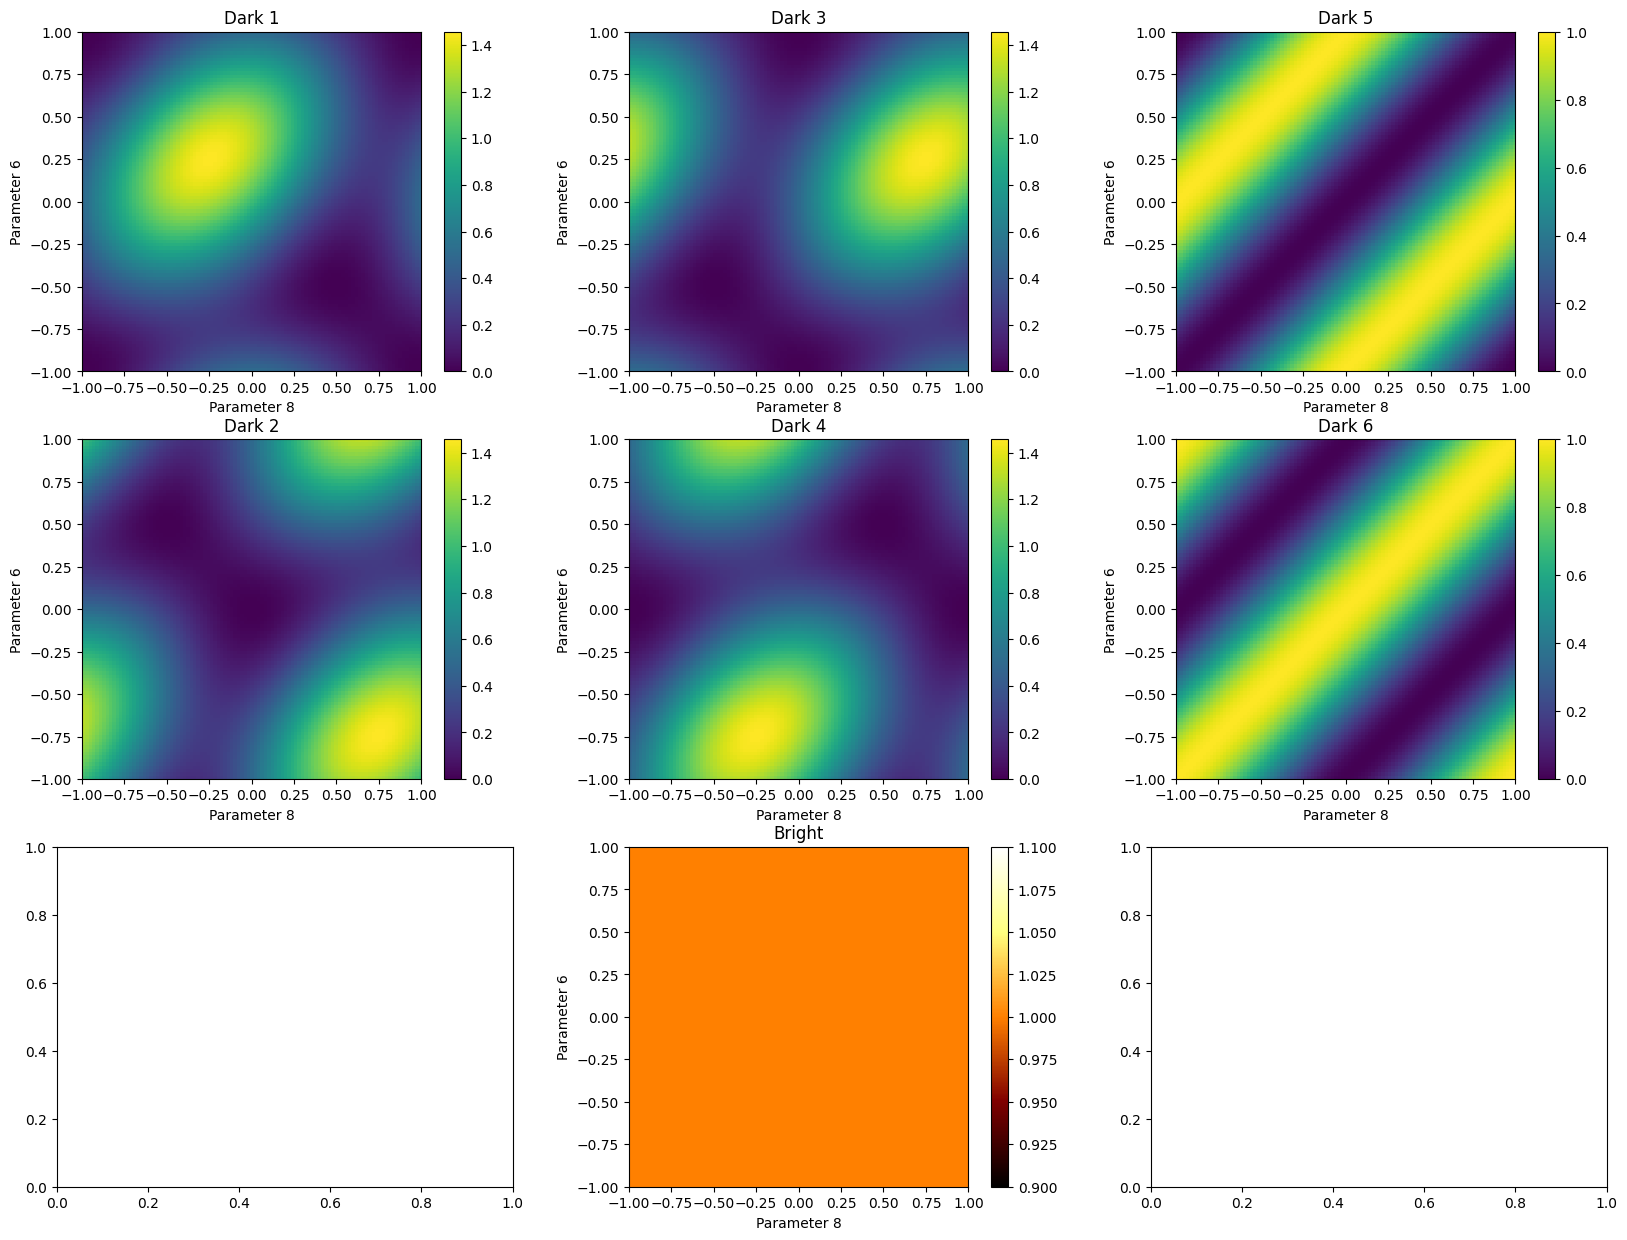

In [72]:
def scan(plot_intermediate_states=False):
    
    scan_on_parameters = (6,8) # Select 2 values from 1 to 14

    # Scan shift power parameter space
    scan = np.linspace(-1, 1, 101)
    null_depths = np.zeros((6, len(scan), len(scan)))
    brights = np.zeros((len(scan), len(scan)))
    first_layer_nulls = np.zeros((4, len(scan), len(scan)))
    second_layer_nulls = np.zeros((4, len(scan), len(scan)))

    if plot_intermediate_states:
        fig_b, axs_b = plt.subplots(2,4, figsize=(20,10))

    fig, axs = plt.subplots(3,3, figsize=(20,15))

    for i, scan1 in enumerate(scan):
        for j, scan2 in enumerate(scan):
            parameters = [0.5, 0, -0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            parameters[scan_on_parameters[0]-1] = scan1
            parameters[scan_on_parameters[1]-1] = scan2
            bright, darks, inter = kn0(star_light, parameters)

            if plot_intermediate_states:
                for k, null in enumerate(inter['first_nuller_layer']):
                    first_layer_nulls[k,i,j] = np.abs(null)**2

                for k, null in enumerate(inter['second_nuller_layer']):
                    second_layer_nulls[k,i,j] = np.abs(null)**2

            for k, dark in enumerate(darks):
                null_depths[k,i,j] = np.abs(dark)**2 # np.log(np.abs(dark)**2 / np.abs(bright)**2)
                brights[i,j] = np.abs(bright)**2

    if plot_intermediate_states:
        for k in range(4):
            p = axs_b[0, k]
            p.set_title(f"N{k//2} - {k%2}")
            im = p.imshow(first_layer_nulls[k])
            p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
            p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
            plt.colorbar(im)

        for k in range(4):
            p = axs_b[1, k]
            p.set_title(f"N{k//2+2} - {k%2}")
            im = p.imshow(second_layer_nulls[k])
            p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
            p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
            plt.colorbar(im)

    for k in range(6):
        p = axs[k%2, k//2]
        p.set_title(f"Dark {k+1}")
        im = p.imshow(null_depths[k], extent=[-1, 1, -1, 1])
        p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
        p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
        plt.colorbar(im)

    p = axs[2,1]
    p.set_title(f"Bright")
    im = p.imshow(brights, extent=[-1, 1, -1, 1], cmap="afmhot")
    p.set_xlabel(f"Parameter {scan_on_parameters[1]}")
    p.set_ylabel(f"Parameter {scan_on_parameters[0]}")
    plt.colorbar(im)
    
    plt.show()

scan(False)